In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from collections import defaultdict
from torchvision import models

from datasets import ImagenetDataset
from fooling_model import VGG19FoolingModel
from utils import construct_perturbation, calculate_fooling_rate, for_imagenet, process_image

In [2]:
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [44]:
BATCH_SIZE = 64
p = np.inf
q = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgs_dir = 'imgs'
imgs_paths = [os.path.join(imgs_dir, img_name) for img_name in os.listdir(imgs_dir)]
train_paths = np.random.choice(imgs_paths, size=BATCH_SIZE, replace=False)
val_paths = list(set(imgs_paths) - set(train_paths))
train_dataset = ImagenetDataset(train_paths, device)
val_dataset = ImagenetDataset(val_paths, device)

In [36]:
fooling_model = VGG19FoolingModel(models.vgg19(pretrained=True)).to(device)
fooling_model.eval();

In [37]:
perturbation = construct_perturbation(
    model=fooling_model,
    layer_id=fooling_model.LAYERS_IDS['block2_pool'],
    train_batch=train_dataset[:],
    perturb_norm=1,
    p=p,
    q=q
)

In [46]:
norm_pool = np.linspace(0, 25, 128)

batch = torch.stack([
    val_dataset[32] + (perturbation * norm)
    for norm in norm_pool
])

In [47]:
perturb_outputs = fooling_model.full_forward(for_imagenet(batch))

In [48]:
perturb_probs = torch.softmax(perturb_outputs, 1)

In [49]:
top_probs = defaultdict(list)
for probs in perturb_probs:
    for position, prob in enumerate(sorted(probs, reverse=True)[:5]):
        top_probs[position].append(prob)    

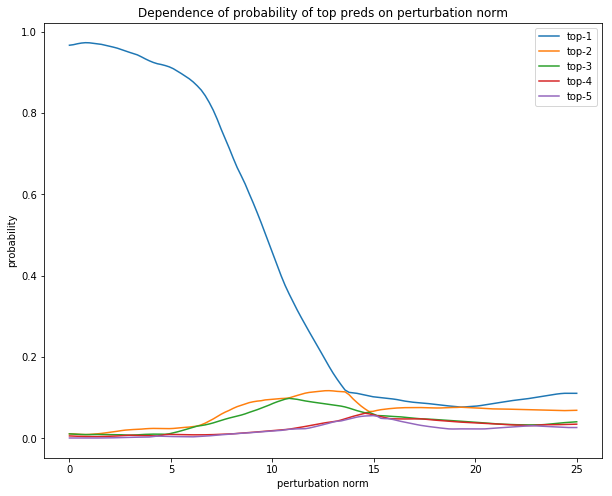

In [50]:
plt.figure(figsize=(10, 8))
plt.title('Dependence of probability of top preds on perturbation norm')
plt.xlabel('perturbation norm')
plt.ylabel('probability')
for position, probs in top_probs.items():
    plt.plot(norm_pool, probs, label='top-{}'.format(position + 1))
plt.legend()

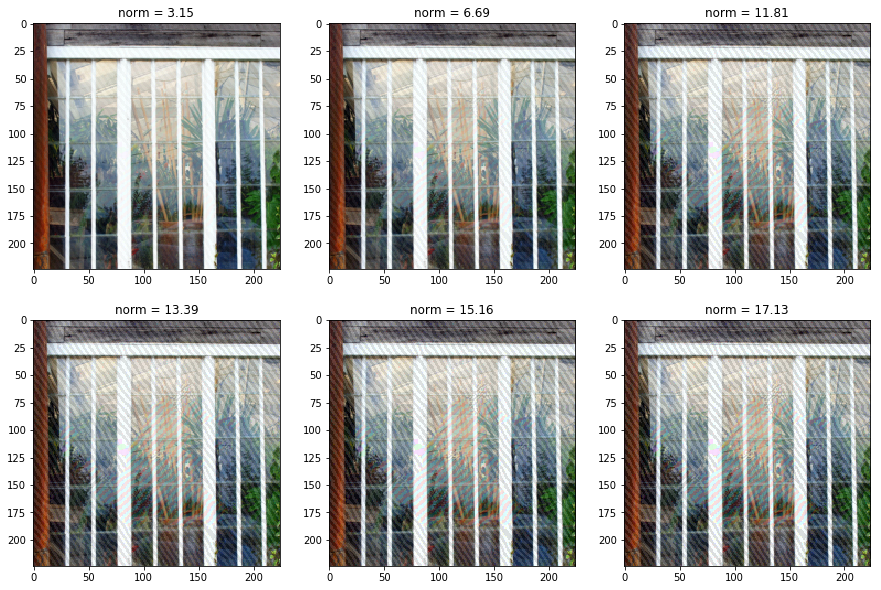

In [53]:
plt.figure(figsize=(3 * 5, 2 * 5))
random_norm_idxs = sorted(np.random.choice(len(norm_pool), replace=False, size=6))
for plot_idx, norm_idx in enumerate(random_norm_idxs, 1):
    plt.subplot(2, 3, plot_idx)
    plt.title('norm = {:.2f}'.format(norm_pool[norm_idx]))
    plt.imshow(process_image(batch[norm_idx]))